# CV - CNN Filter Pruning - MNIST - Part 1

By [Akshaj Verma](https://akshajverma.com)

This notebook takes you through the implementation of filter pruning of CNNs using the MNIST dataset on PyTorch.

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
%matplotlib inline
torch.manual_seed(1)

## Load MNIST Dataset

In [3]:
data_transform = transforms.Compose([
    transforms.ToTensor()
#     transforms.Normalize((0.1307,), (0.3081,))
])

train = datasets.MNIST('../../../data/computer_vision/mnist', train=True, download=True, transform=data_transform)

test = datasets.MNIST('../../../data/computer_vision/mnist', train=False, download=True, transform=data_transform)

## Data Loader

In [4]:
BATCH_SIZE = 64

In [5]:
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

## EDA

### Input-output size

In [6]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

print("Input images (batch, channels, height, width): ", images.size())
print("Output labels: ", labels.size())

Input images (batch, channels, height, width):  torch.Size([64, 1, 28, 28])
Output labels:  torch.Size([64])


### Example image from training data

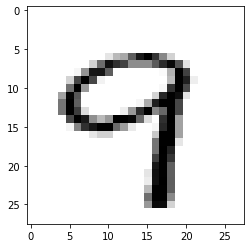

In [7]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## Define a CNN for classification

In [8]:
class MnistClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(MnistClassifier, self).__init__()
        
        self.conv = nn.Conv2d(1, 4, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
        self.fc = nn.Linear(13*13*4, num_classes)
        
    def forward(self, x):
        out = self.relu(self.conv(x))
        out = self.maxpool(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

**Skip the following part and directly load a saved model given a few cells below.**

## Train a CNN for classification

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
EPOCHS = 7
LEARNING_RATE = 0.001

model = MnistClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

In [ ]:
model.train()
for e in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        loss = criterion(y_pred_probs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        batch_acc = (y_pred == y_batch).sum().item()/BATCH_SIZE
        
        epoch_loss += loss.item()
        epoch_acc += batch_acc
    
    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.5f}')    

## Save the model

In [ ]:
torch.save(model.state_dict(), "mnist_big")

## Load Model (on CPU)

In [9]:
device = torch.device('cpu')
model = MnistClassifier()
model.load_state_dict(torch.load("mnist_big", map_location=device))

<All keys matched successfully>

## Test model 

In [11]:
print("Device: ", device)
params_before_pruning = sum(p.numel() for p in model.parameters())

Device:  cpu


In [12]:
y_pred_list = []
y_true_list = []

In [13]:
%%timeit 

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

2.82 s ± 55.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
print(classification_report(y_true_list, y_pred_list))
print("\nParameters before pruning: ", params_before_pruning)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7840
           1       0.98      0.97      0.97      9080
           2       0.95      0.93      0.94      8256
           3       0.97      0.93      0.95      8080
           4       0.94      0.97      0.96      7856
           5       0.94      0.94      0.94      7136
           6       0.98      0.97      0.97      7664
           7       0.94      0.92      0.93      8224
           8       0.84      0.95      0.89      7792
           9       0.96      0.91      0.94      8072

    accuracy                           0.95     80000
   macro avg       0.95      0.95      0.95     80000
weighted avg       0.95      0.95      0.95     80000


Parameters before pruning:  6810


## Channel Pruning

### Find a filter with lowest L1 norm

In [15]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if name == "conv.weight":
            print (name, ": ",  param.shape, "\n", param.data, "\n")
            print("=" * 100)
            for wt in param.data:
                print(torch.norm(wt))

conv.weight :  torch.Size([4, 1, 3, 3]) 
 tensor([[[[ 3.3874e-02,  1.2109e-01,  5.0049e-01],
          [-1.5165e-01, -4.3195e-02,  1.3526e-02],
          [-4.5370e-01, -9.9016e-01, -3.3812e-01]]],


        [[[ 2.4854e-03,  4.1072e-01, -1.7655e-01],
          [-4.2791e-01,  6.6795e-01, -2.0674e-01],
          [ 3.3002e-01,  1.6327e-01,  7.4090e-02]]],


        [[[ 1.6852e-01, -2.8468e-01, -6.6331e+00],
          [-3.1287e-01, -1.1904e-01, -6.5325e+00],
          [-2.7918e-01, -2.2543e-01, -2.4872e-01]]],


        [[[-2.3184e-01, -6.8228e+00, -3.1576e+00],
          [-6.7073e-01, -2.5972e-01, -1.6205e-02],
          [-1.1910e-01,  4.7707e-01,  2.3824e-01]]]]) 

tensor(1.2617)
tensor(1.0064)
tensor(9.3318)
tensor(7.5757)


### Make the filter with lowest L1 norm 0

In [16]:
filter_norm_list = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if name == "conv.weight":
            print ("Before \n", name, ": ",  param.shape, "\n", param.data, "\n")
            print("=" * 100)
            for wt in param.data:
                filter_norm_list.append(torch.norm(wt))
            
print("Filter norm list: ", filter_norm_list)
                
smallest_norm_filter_index = filter_norm_list.index(min(filter_norm_list))
print("\nIndex of filter with smallest L1 norm: ", smallest_norm_filter_index)

model.conv.weight.data[smallest_norm_filter_index] = 0

print("=" * 100)

for name, param in model.named_parameters():
    if param.requires_grad:
        if name == "conv.weight":
            print("After \n", name, ": ",  param.shape, "\n", param.data, "\n")

Before 
 conv.weight :  torch.Size([4, 1, 3, 3]) 
 tensor([[[[ 3.3874e-02,  1.2109e-01,  5.0049e-01],
          [-1.5165e-01, -4.3195e-02,  1.3526e-02],
          [-4.5370e-01, -9.9016e-01, -3.3812e-01]]],


        [[[ 2.4854e-03,  4.1072e-01, -1.7655e-01],
          [-4.2791e-01,  6.6795e-01, -2.0674e-01],
          [ 3.3002e-01,  1.6327e-01,  7.4090e-02]]],


        [[[ 1.6852e-01, -2.8468e-01, -6.6331e+00],
          [-3.1287e-01, -1.1904e-01, -6.5325e+00],
          [-2.7918e-01, -2.2543e-01, -2.4872e-01]]],


        [[[-2.3184e-01, -6.8228e+00, -3.1576e+00],
          [-6.7073e-01, -2.5972e-01, -1.6205e-02],
          [-1.1910e-01,  4.7707e-01,  2.3824e-01]]]]) 

Filter norm list:  [tensor(1.2617), tensor(1.0064), tensor(9.3318), tensor(7.5757)]

Index of filter with smallest L1 norm:  1
After 
 conv.weight :  torch.Size([4, 1, 3, 3]) 
 tensor([[[[ 0.0339,  0.1211,  0.5005],
          [-0.1517, -0.0432,  0.0135],
          [-0.4537, -0.9902, -0.3381]]],


        [[[ 0.0000,  0

## Test after making a filter 0

In [ ]:
y_pred_list = []
y_true_list = []

In [17]:
%%timeit

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

              precision    recall  f1-score   support

           0       0.93      0.66      0.77       980
           1       0.92      0.96      0.94      1135
           2       0.81      0.93      0.87      1032
           3       0.90      0.80      0.85      1010
           4       0.97      0.88      0.92       982
           5       0.67      0.87      0.76       892
           6       0.95      0.93      0.94       958
           7       0.94      0.87      0.91      1028
           8       0.72      0.80      0.76       974
           9       0.90      0.90      0.90      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000


Parameters before pruning:  6810
CPU times: user 20.4 s, sys: 240 ms, total: 20.6 s
Wall time: 3.57 s


In [ ]:
print(classification_report(y_true_list, y_pred_list))
print("\nParameters before pruning: ", params_before_pruning)

## Drop the filter with all 0s

In [18]:
model.conv.weight.data = model.conv.weight.data[1:]
model.conv.bias.data = model.conv.bias.data[1:]

In [19]:
for name, param in model.named_parameters():
    if param.requires_grad:
        if name == "conv.weight" or name == "conv.bias":
            print (name, ": ",  param.shape, "\n", param.data, "\n")                    

conv.weight :  torch.Size([3, 1, 3, 3]) 
 tensor([[[[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[ 0.1685, -0.2847, -6.6331],
          [-0.3129, -0.1190, -6.5325],
          [-0.2792, -0.2254, -0.2487]]],


        [[[-0.2318, -6.8228, -3.1576],
          [-0.6707, -0.2597, -0.0162],
          [-0.1191,  0.4771,  0.2382]]]]) 

conv.bias :  torch.Size([3]) 
 tensor([-0.7288, -6.8801, -0.1915]) 



## Change model architecture

In [20]:
model.conv = nn.Conv2d(1, 3, kernel_size=3, stride=1)
model.fc = nn.Linear(13*13*3, 10)

In [21]:
print("Device: ", device)
params_after_pruning = sum(p.numel() for p in model.parameters())

Device:  cpu


## Test accuracy of changed architecture

In [22]:
y_pred_list = []
y_true_list = []

In [23]:
%%timeit

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

3.3 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
print(classification_report(y_true_list, y_pred_list))
print("Parameters after pruning: ", params_after_pruning)

              precision    recall  f1-score   support

           0       0.14      0.70      0.23      7840
           1       0.00      0.00      0.00      9080
           2       0.00      0.00      0.00      8256
           3       0.01      0.01      0.01      8080
           4       0.17      0.04      0.06      7856
           5       0.09      0.40      0.15      7136
           6       0.00      0.00      0.00      7664
           7       0.36      0.00      0.01      8224
           8       0.00      0.00      0.00      7792
           9       0.00      0.00      0.00      8072

    accuracy                           0.11     80000
   macro avg       0.08      0.11      0.05     80000
weighted avg       0.08      0.11      0.04     80000

Parameters after pruning:  5110


/home/akshaj/miniconda3/envs/toothless/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Finetune Pruned Model

In [26]:
EPOCHS = 3
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

print(device)
print(model)

cpu
MnistClassifier(
  (conv): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc): Linear(in_features=507, out_features=10, bias=True)
)


In [27]:
model.train()
for e in range(EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        loss = criterion(y_pred_probs, y_batch)
        
        loss.backward()
        optimizer.step()
        
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        batch_acc = (y_pred == y_batch).sum().item()/BATCH_SIZE
        
        epoch_loss += loss.item()
        epoch_acc += batch_acc
    
    print(f'Epoch {e+0:02}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.5f}')    

Epoch 00: | Loss: 0.32278 | Acc: 0.90705
Epoch 01: | Loss: 0.20767 | Acc: 0.94085
Epoch 02: | Loss: 0.19505 | Acc: 0.94744


## Test Accuracy of pruned model

In [28]:
y_pred_list = []
y_true_list = []

In [31]:
%%timeit

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred_probs = model(X_batch)
        _, y_pred = torch.max(y_pred_probs, dim = 1)
        
        y_pred_list.append(y_pred.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

10.3 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
print(classification_report(y_true_list, y_pred_list))
print("Parameters after pruning: ", params_after_pruning)

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      7840
           1       0.96      0.97      0.97      9080
           2       0.96      0.94      0.95      8256
           3       0.95      0.96      0.96      8080
           4       0.95      0.95      0.95      7856
           5       0.97      0.92      0.94      7136
           6       0.97      0.97      0.97      7664
           7       0.94      0.95      0.94      8224
           8       0.91      0.95      0.93      7792
           9       0.94      0.92      0.93      8072

    accuracy                           0.95     80000
   macro avg       0.95      0.95      0.95     80000
weighted avg       0.95      0.95      0.95     80000

Parameters after pruning:  5110
